# Gaussian Process

## Introduction

[Gaussian process](https://en.wikipedia.org/wiki/Gaussian_process) has been used in supervised, unsupervised, and even reinforcement learning problems. It has a beautiful mathematical theory (for an overview of the subject, see [1]). In particular, its distribution can be considered as a distribution over functions. Many machine learning models give specific predictions, not how uncertainty the predictions are. Gaussian process particularly helps us solve such problems. Currently, there is a simple implementation of Gaussian process regression model at `pyro.contrib.gp` module. We will try to use it in this tutorial. The model is defined as
$$f \sim \mathcal{GP}\left(0, \mathbf{K}_f(x, x')\right)$$
and
$$y = f + \epsilon,\quad \epsilon \sim \mathcal{N}\left(0, \beta^{-1}\mathbf{I}\right).$$

We will use [radial basis function kernel](https://en.wikipedia.org/wiki/Radial_basis_function_kernel) (RBF kernel) as the kernel of Gaussian process:
$$ k(x,x') = \sigma^2 \exp\left(-\frac{\|x-x'\|^2}{2l^2}\right),$$
where $\sigma^2$ is variance and $l$ is lengthscale of the RBF kernel.

## Prepare

First, we need import necessary modules.

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch.autograd import Variable

import pyro
from pyro.contrib.gp.kernels import RBF
from pyro.contrib.gp.models import GPRegression
from pyro.distributions.log_normal import LogNormal
from pyro.distributions.normal import Normal
from pyro.distributions.uniform import Uniform
from pyro.infer import SVI
from pyro.optim import Adam
from pyro.util import ng_ones, ng_zeros

It is better to make visualizations for Gaussian process' implementation. So we create a convenient function to plot.

In [2]:
def plot(model=None, n_sample=0):
    plt.figure(figsize=(12, 6))
    plt.plot(X.data.numpy(), y.data.numpy(), 'kx')  # plot data
    if model is not None:
        Z = Variable(torch.linspace(-0.5, 5.5, 100), volatile=True)  # new input
        mean, cov = model(Z)  # mean and covariance matrix of output's Gaussian distribution
        sd = cov.diag().sqrt()  # standard derivation at each input
        plt.plot(Z.data.numpy(), mean.data.numpy(), 'r', lw=2)  # plot the mean
        plt.fill_between(Z.data.numpy(),
                         mean.data.numpy() - 2*sd.data.numpy(),
                         mean.data.numpy() + 2*sd.data.numpy(),
                         color='C0', alpha=0.3)  # fill the interval (mean-2.sd, mean+2.sd)
    if n_sample > 0:  # plot the samples
        samples = np.random.multivariate_normal(mean.data.numpy(), cov.data.numpy(),
                                                size=n_sample, check_valid='ignore')
        plt.plot(Z.data.numpy(), samples.T, 'C0', lw=2, alpha=0.4)
    plt.xlim(-0.5, 5.5)
    plt.ylim(-3, 3)

## Data

The data consists of $20$ points sampled from
$$ y = 0.5\sin(3x) + \epsilon, \quad \epsilon \sim \mathcal{N}(0, 0.5).$$

In [3]:
# source: http://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy.html
N = 20
X = Uniform(ng_zeros(N), ng_ones(N)*5).sample()
y = 0.5 * torch.sin(3*X) + Normal(ng_zeros(N), ng_ones(N)*0.5).sample()

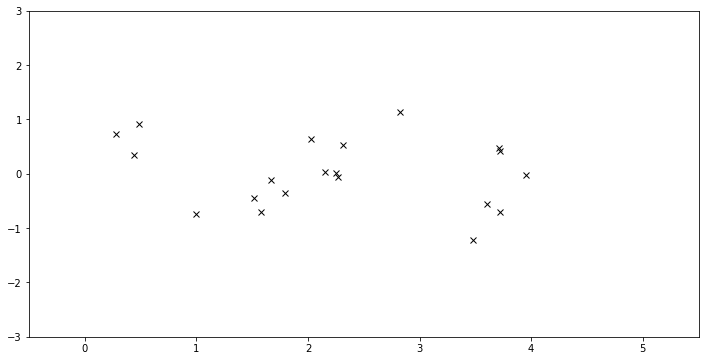

In [4]:
plot()

## Define model

In [5]:
kernel = RBF()
# the default value noise=1 is so large w.r.t. to this data
# so we choose a smaller noise
gpr = GPRegression(X, y, kernel, noise=torch.Tensor([0.01]))

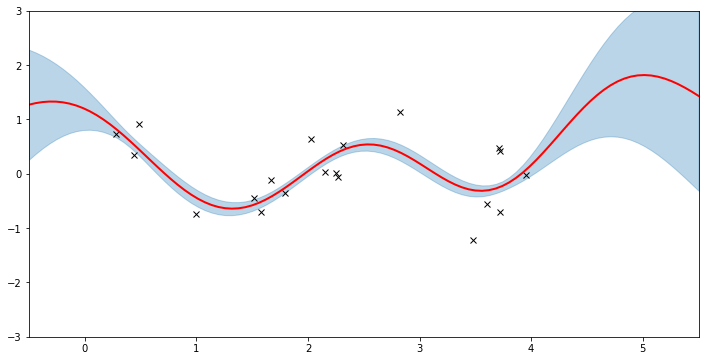

In [6]:
plot(gpr)

## Inference

In [7]:
optim = Adam({"lr": 0.001})
svi = SVI(gpr.model, gpr.guide, optim, loss="ELBO")
losses = []
for i in range(1000):
    losses.append(svi.step())

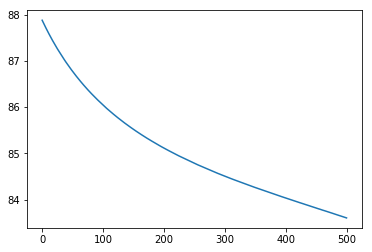

In [8]:
# look at the loss
plt.plot(losses[-500:])

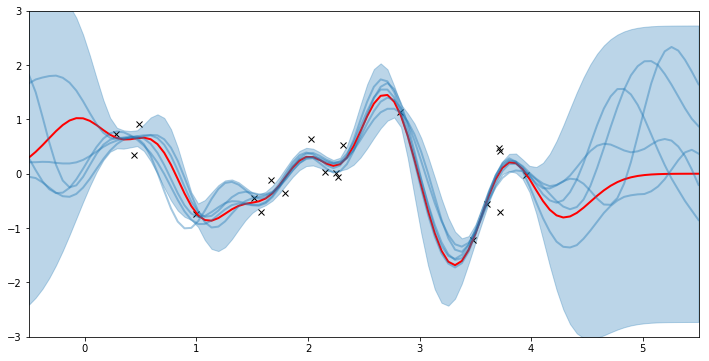

In [9]:
# see the inference result
plot(gpr, n_sample=5)

In [10]:
# observe the parameters
pyro.get_param_store().named_parameters()

dict_items([('RBF$$$variance', Parameter containing:
 1.8593
[torch.FloatTensor of size 1]
), ('RBF$$$lengthscale', Parameter containing:
 0.3400
[torch.FloatTensor of size 1]
)])

With RBF kernel, the larger lengthscale, we get the smoother samples (this can be deduced from the formula of $K$: the larger lengthscale, the more likeliness that $K$ will approach $1$, which in turn reflects the values of two points $x$ and $x'$ are similar). Variance parameter controls the derivation from the mean (besides the fixed noise `0.01`). Comparing the initial plot with the last plot, we can see that the initial one is smoother and less variant. However, the second plot fits the data better.

In some cases, the inference will make `variance` or `lengthscale` become negative numbers. To solve that problem, we have to force these parameters to be positive. To do that, we need to use some kind of transform (e.g. `exp` or `softplus`), which has not been implemented in PyTorch or Pyro yet. Another way is to put some constrained priors to these parameters. We will follow the later method in this tutorial.

### Fit the model using MAP

We need to define the priors for parameters. Beside it is more reliable approach, it will also help dealing with the constraints of parameters.

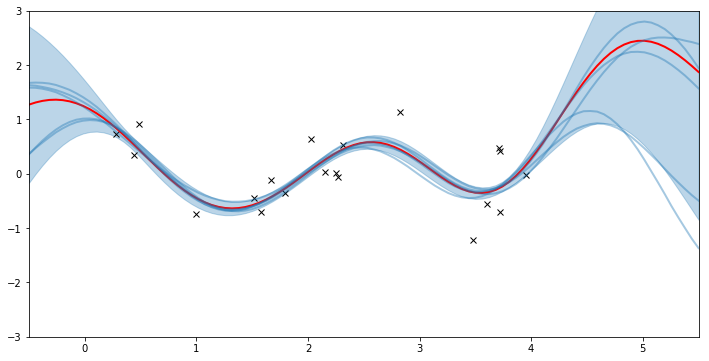

In [16]:
gpr.priors = {"lengthscale": LogNormal(ng_zeros(1), ng_ones(1)),
              "variance": LogNormal(ng_zeros(1), ng_ones(1))}
# we need to reset param store
pyro.clear_param_store()
optim = Adam({"lr": 0.001})
svi = SVI(gpr.model, gpr.guide, optim, loss="ELBO")
losses = []
for i in range(1000):
    losses.append(svi.step())
plot(gpr, n_sample=5)

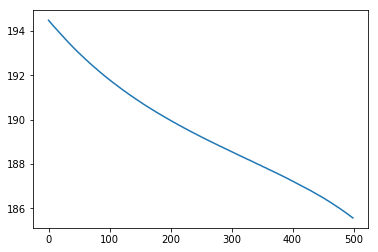

In [17]:
plt.plot(losses[-500:]);

We can see that the model might still learn. So we run more iterations.

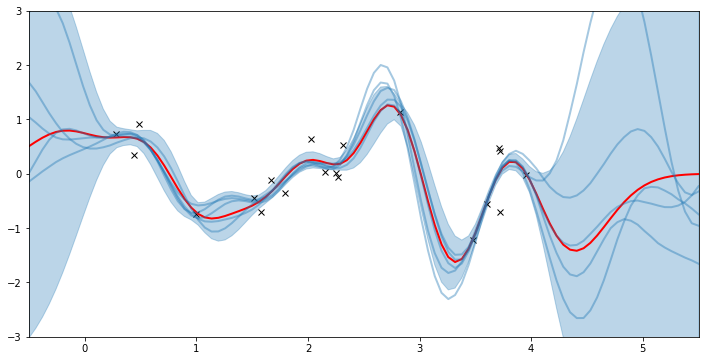

In [18]:
for i in range(1000):
    svi.step()
plot(gpr, n_sample=5)

Now, look at the parameters, we can see that the names of parameters have been changed. The reason is that: when we put priors to parameters of our kernel, they become random variables (not `torch.nn.Parameter` anymore). Inference will learn the parameters with trailing `_MAP` at the end.

In [19]:
pyro.get_param_store().named_parameters()

dict_items([('RBF$$$lengthscale_MAP', Variable containing:
 0.4114
[torch.FloatTensor of size 1]
), ('RBF$$$variance_MAP', Variable containing:
 3.4011
[torch.FloatTensor of size 1]
)])

If we think that our target function is smoother, we can put prior for `lengthscale` at higher region.

dict_items([('RBF$$$lengthscale_MAP', Variable containing:
 241.4102
[torch.FloatTensor of size 1]
), ('RBF$$$variance_MAP', Variable containing:
 4.6461
[torch.FloatTensor of size 1]
)])


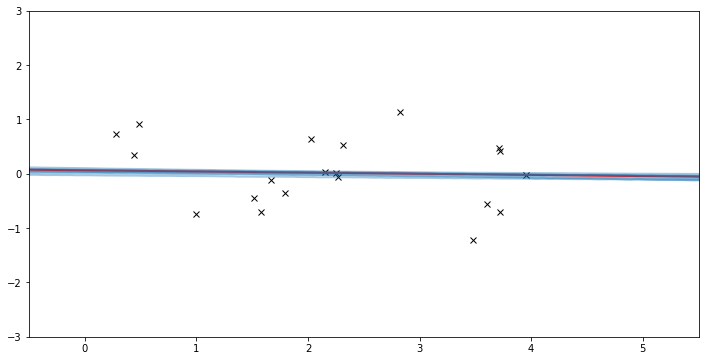

In [20]:
gpr.priors = {"lengthscale": LogNormal(ng_ones(1)*5, ng_ones(1)),
              "variance": LogNormal(ng_zeros(1), ng_ones(1))}
pyro.clear_param_store()
optim = Adam({"lr": 0.001})
svi = SVI(gpr.model, gpr.guide, optim, loss="ELBO", trace_graph=True)
losses = []
for i in range(3000):
    svi.step()
print(pyro.get_param_store().named_parameters())
plot(gpr, n_sample=5)

The result is a straight line because we set the initial lengthscale so high.

## Some remarks

+ In Gaussian Process, we usually have to solve the equation $Kx = y$, where $K$ is a positive covariance matrix. An efficiency and numerically-stable method to obtain the solution is to use [Cholesky decomposition](https://en.wikipedia.org/wiki/Cholesky_decomposition). First, we decompose $K = LL^T$, where $L$ is a lower triangular matrix. Then, we solve in turn $Lz = y$ and $L^Tx = z$.

+ The Cholesky decomposition `torch.potrf` usually throws the `RuntimeError`: "Lapack Error in potrf : the leading minor of order {} is not positive definite". The error tells itself: while decomposing, some eigenvalues of covariance matrix are approximately $0$ (and turn out to be negative). To deal with such error, instead of sampling $f$ from the decomposed lower triangle $L$ of $K(X, X)$ and sampling $y$ from $f$ with `noise`, we have to add `noise` to $K$ before decomposing matrix. Due to the `noise` component, all eigenvalues will be positive. Another way to deal with this error is to introduce the notion `jitter`. We will add a small positive term (named `jitter`) into the diagonal part of $K$ before decomposing the covariance matrix. Adding `jitter` is helpful when using Gaussian Process for (e.g.) classification problem.

+ Looking at the implementation of Gaussian process regression, we can see that it is quite simple. However, it demonstates how flexible Pyro is. Beside Kernel, as in [GPy](http://sheffieldml.github.io/GPy/), there are other components such as Likelihood and Mean_function. For example, Bernoulli likelihood is used in classification problems, Poisson likelihood is used in Poisson regression problems. All of them can be made modular (a.k.a. a subclass of `nn.Module`) like Kernels.

+ Due to the flexibility of Pyro, we believe that it is just a matter of time until we have an established Gaussian process library in Pyro (contribution needed). The next release of PyTorch (version 0.4) will introduce a mature `torch.distributions` library, which will make probabilistic programming in Pyro much easier. In that version, changes such as "supporting scalar tensors" or "merging Tensor and Variable class" will also simplify the implementations of Gaussian Process models a lot. Stay tuned!

## Reference

[1] `Deep Gaussian processes and variational propagation of uncertainty`,<br />&nbsp;&nbsp;&nbsp;&nbsp;
Andreas Damianou